In [164]:
import io
import csv
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [166]:
with open("/content/bbc-text.csv", "r") as f:
  print("Header: ", f.readline())
  print("Data: ", f.readline())

Header:  category,text

Data:  tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. t

In [167]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN=120
PADDING = "post"
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = 0.8

In [168]:
def remove_stopwords(sentence):
  stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
  sentence = sentence.lower()
  words = sentence.split()
  s = " ".join([w for w in words if not w in stopwords])
  return s

In [175]:
def parse_data(filename):
  sentences = []
  labels = []
  with open(filename, "r") as f:
    reader = csv.reader(f, delimiter=",")
    next(reader)
    for line in reader:
      labels.append(line[0])
      sentences.append(remove_stopwords(line[1]))

  return sentences, labels

In [170]:
def train_val_split(sentences, labels, training_split):
  train_size = int(training_split * len(sentences))
  train_sentences = sentences[:train_size]
  test_sentences = sentences[train_size:]
  train_labels = labels[:train_size]
  test_labels = labels[train_size:]

  return train_sentences, test_sentences, train_labels, test_labels

In [171]:
def fit_tokenizer(train_sentences, num_words, oov_token):
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
  tokenizer.fit_on_texts(train_sentences)
  return tokenizer

In [172]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
  seqs = tokenizer.texts_to_sequences(sentences)
  padded = pad_sequences(seqs, padding=padding, maxlen=maxlen)
  return padded

In [173]:
def tokenize_labels(labels, split_labels):
  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(labels)
  label_seq = label_tokenizer.texts_to_sequences(split_labels)
  label_seq = np.array(label_seq)-1
  return label_seq

In [176]:
sentences, labels = parse_data("/content/bbc-text.csv")

In [177]:
train_sentences, test_sentences, train_labels, test_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

In [178]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)

In [181]:
train_padded = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
test_padded = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

In [182]:
train_label_seq = tokenize_labels(labels, train_labels)
test_label_seq = tokenize_labels(labels, test_labels)

In [183]:
train_label_seq[:5]

array([[3],
       [1],
       [0],
       [0],
       [4]])

In [189]:
def create_model():
  model = tf.keras.Sequential([tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
                               tf.keras.layers.GlobalAveragePooling1D(),
                               tf.keras.layers.Dense(24, activation="relu"),
                               tf.keras.layers.Dense(5, activation="softmax")])
  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

In [190]:
model = create_model()
history = model.fit(train_padded, train_label_seq, epochs=10, validation_data=(test_padded, test_label_seq))

Epoch 1/10
56/56 [==============================] - 2s 26ms/step - loss: 1.6010 - accuracy: 0.3365 - val_loss: 1.5884 - val_accuracy: 0.4360
Epoch 2/10
56/56 [==============================] - 0s 3ms/step - loss: 1.5696 - accuracy: 0.3270 - val_loss: 1.5427 - val_accuracy: 0.4449
Epoch 3/10
56/56 [==============================] - 0s 4ms/step - loss: 1.4899 - accuracy: 0.4539 - val_loss: 1.4256 - val_accuracy: 0.5056
Epoch 4/10
56/56 [==============================] - 0s 3ms/step - loss: 1.3124 - accuracy: 0.5742 - val_loss: 1.2197 - val_accuracy: 0.5888
Epoch 5/10
56/56 [==============================] - 0s 3ms/step - loss: 1.0673 - accuracy: 0.6876 - val_loss: 0.9844 - val_accuracy: 0.7955
Epoch 6/10
56/56 [==============================] - 0s 3ms/step - loss: 0.8186 - accuracy: 0.8556 - val_loss: 0.7743 - val_accuracy: 0.8629
Epoch 7/10
56/56 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.9202 - val_loss: 0.6107 - val_accuracy: 0.8899
Epoch 8/10
56/56 [=

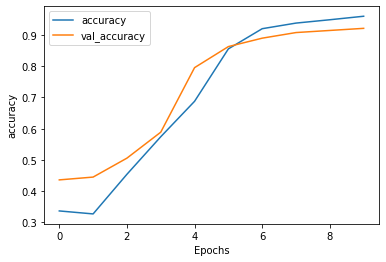

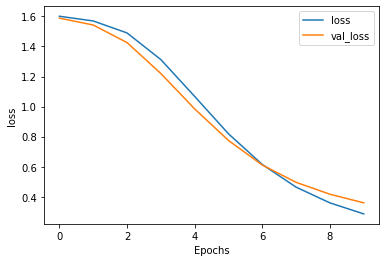

In [191]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")